In [1]:
import dill
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import numpy as np

In [2]:
model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/SASRec-vanilla.dill", "rb")
#model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/Sasrec-rss-lambdarank-0.01.dill", "rb")
#model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/Sasrec-rss-lambdarank-0.5.dill", "rb")
#model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/Sasrec-rss-lambdarank-0.5.dill", "rb")
model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_06T10_18_53/checkpoints/Sasrec-rss-lambdarank-0.5.dill", "rb")


In [8]:
# Copyright 2022 The KerasNLP Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Sinusoidal position embedding layer."""

import tensorflow as tf
from tensorflow import keras


class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        seq_length, 
        hidden_size,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength
        self.seq_length = seq_length
        self.hidden_size = hidden_size

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = self.seq_length
        hidden_size = self.hidden_size
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

In [9]:
recommender = dill.load(model_file)

EOFError: Ran out of input

In [20]:
user_ids = recommender.recommender.users.straight

In [21]:
sasrec_recommender = recommender.recommender

In [22]:
def get_attention_maps(user_id, sasrec_recommender):
    inputs = sasrec_recommender.get_model_inputs(user_id)[0]
    with tf.device('/cpu:0'):
        seq, attn = sasrec_recommender.model.get_seq_embedding(inputs)
    return attn[0][0].numpy()

In [23]:
m = get_attention_maps('28507', sasrec_recommender)

In [24]:
maps = []
for n in tqdm.tqdm(range(1000)):
    uid = np.random.choice(list(user_ids.keys()))
    maps.append(get_attention_maps(uid, sasrec_recommender))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.17it/s]


In [25]:
maps = np.array(maps)

In [26]:
mean_attentions  = np.mean(maps, axis=0)

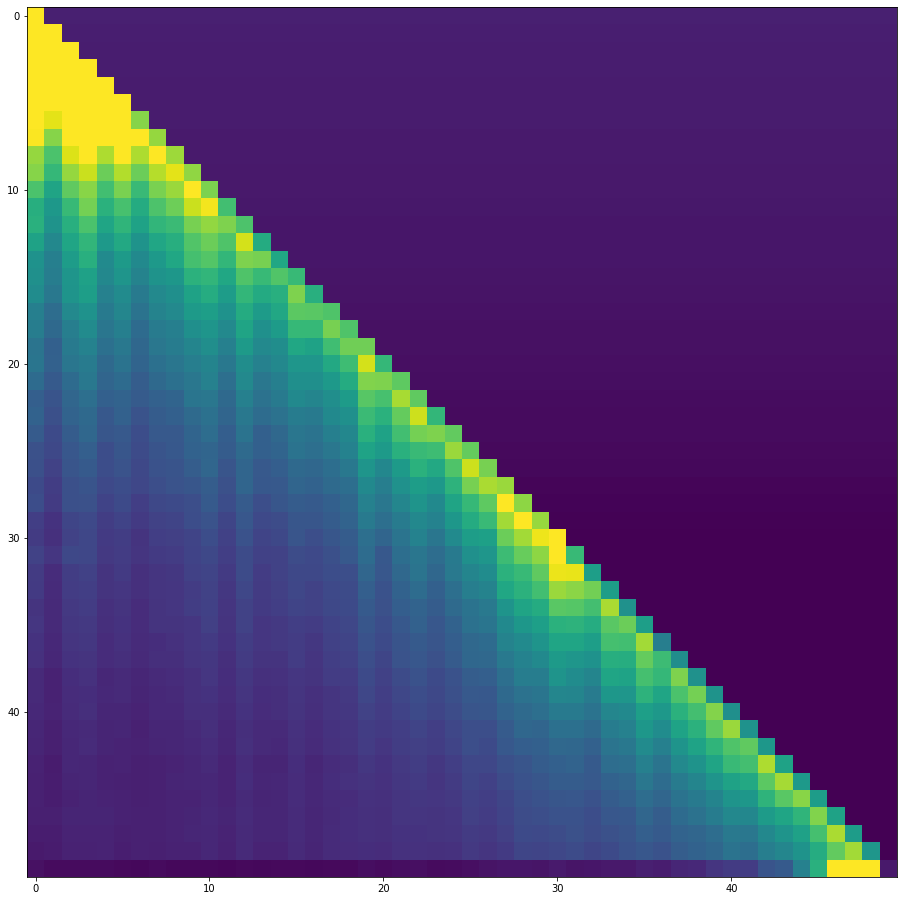

In [27]:
plt.figure(figsize=(16,16))
plt.imshow(mean_attentions, vmax=0.09, vmin=0.0)

In [28]:
res = []
n = 49
a = 0.5
for i in range(n):
    res.append(a ** (n - i))
res = np.array(res) /np.sum(res)

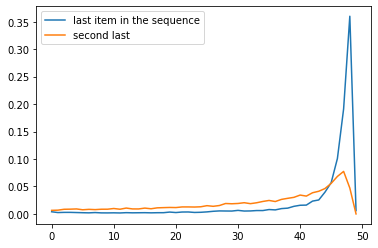

In [29]:
plt.plot(mean_attentions[49], label='last item in the sequence')
plt.plot(mean_attentions[48], label='second last')

#plt.plot(mean_attentions[24][:25], label='25th item in the sequence')
#plt.plot(res, label = 'position_importance')
plt.legend()

In [30]:
rss_weights = np.array([0.00050863, 0.00061887, 0.00092197, 0.0014479 , 0.00090583,
       0.00090679, 0.00081685, 0.00119046, 0.00088777, 0.00057822,
       0.00139008, 0.00110968, 0.00142508, 0.00104092, 0.00105084,
       0.00108611, 0.00110633, 0.00163135, 0.00142438, 0.0030446 ,
       0.00163955, 0.00301373, 0.00228171, 0.00208965, 0.00155316,
       0.00093835, 0.00178353, 0.0017377 , 0.00252213, 0.00173926,
       0.00320056, 0.00308274, 0.00458886, 0.0035606 , 0.0047561 ,
       0.00692631, 0.00971894, 0.0089213 , 0.01161868, 0.01065103,
       0.01554658, 0.0157064 , 0.02285646, 0.03320919, 0.04574714,
       0.06964114, 0.12280825, 0.20446777, 0.34794655, 0.01265421])

In [31]:
vanilla_weights = np.array([0.00723696, 0.00789131, 0.00889317, 0.00740616, 0.00823375,
       0.00879929, 0.00743264, 0.00758507, 0.00899467, 0.00783445,
       0.00634459, 0.00708402, 0.00703078, 0.00810132, 0.00828369,
       0.00845831, 0.00829117, 0.00793688, 0.00801629, 0.00869415,
       0.00855302, 0.01001667, 0.00904213, 0.00945777, 0.00892488,
       0.01191296, 0.01217955, 0.01356116, 0.01392799, 0.01479892,
       0.01614767, 0.01513599, 0.01697625, 0.01921821, 0.01820138,
       0.01843641, 0.02193111, 0.0230982 , 0.02433731, 0.02698987,
       0.02998334, 0.03684098, 0.03525388, 0.04003029, 0.04953673,
       0.050356  , 0.06957363, 0.07372294, 0.08696238, 0.05634372]
    )

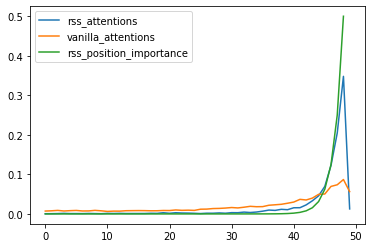

In [32]:
plt.plot(rss_weights, label='rss_attentions')
plt.plot(vanilla_weights, label='vanilla_attentions')
plt.plot(res, label  = 'rss_position_importance')
plt.legend()

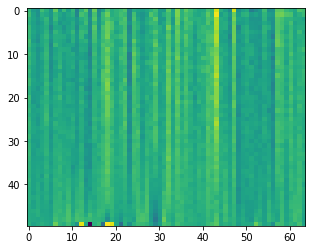

In [33]:
all_items = np.arange(50)
embs = recommender.recommender.model.postion_embedding_layer(all_items)
plt.imshow(embs)

In [6]:
sine_embs = SinePositionEncoding(50, 64)

In [7]:
sine_embs(0)

AttributeError: 'SinePositionEncoding' object has no attribute 'seq_length'